In [ ]:
import networkx as nx
import random
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import openpyxl
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows

def draw_graph(graph, dominating_set):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Get the positions of the nodes
    pos = nx.spring_layout(graph)

    # Draw the nodes of the graph
    nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes()) - set(dominating_set), node_color='blue', ax=ax)
    nx.draw_networkx_nodes(graph, pos, nodelist=dominating_set, node_color='red', ax=ax)

    # Draw the edges of the graph
    nx.draw_networkx_edges(graph, pos, ax=ax)

    # Draw the labels of the nodes
    nx.draw_networkx_labels(graph, pos, ax=ax)

    # Display the graph
    plt.show()



def generate_graph():
    # Create an empty graph
    graph = nx.Graph()

    # Add nodes to the graph
    for node in range(ord('A'), ord('I')+1):
        graph.add_node(chr(node))

    # Add edges to the graph to form a complete graph
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            if node1 != node2:
                # Add an edge with a random spreading factor between 7 and 12
                graph.add_edge(node1, node2, spreading_factor=random.randint(7, 12))

    # Generate a minimum spanning tree from the complete graph
    tree = nx.minimum_spanning_tree(graph, weight='spreading_factor')

    # Add some random edges to the tree to introduce cycles
    edges = list(graph.edges)
    random.shuffle(edges)
    for edge in edges:
        if edge not in tree.edges:
            tree.add_edge(*edge, spreading_factor=graph.edges[edge]['spreading_factor'])
            if nx.is_connected(tree):
                break

    return tree

def create_empty_schedule(num_channels, num_time_slots):
    # Create an empty schedule with the given number of channels and time slots
    schedule = [['' for _ in range(num_time_slots)] for _ in range(num_channels)]
    return schedule

def modify_schedule(schedule, channel, time_slot, value):
    # Modify the given time slot in the given channel with the given value
    schedule[channel][time_slot] = value
    return schedule


def compute_dominating_set(graph):
    # Compute a dominating set for the graph
    dominating_set = nx.dominating_set(graph)
    return dominating_set

def list_transmissions(graph, dominating_set):
    transmissions = {}

    # For each node in the dominating set
    for node in dominating_set:
        # Use BFS to find all 2nd-hop neighbors
        bfs_tree = nx.bfs_tree(graph, node, depth_limit=2)
        neighbors = list(bfs_tree.nodes)

        # Initialize the list of transmissions for the current node
        transmissions[node] = []

        # Add transmissions from the node to its direct neighbors
        for neighbor in graph.neighbors(node):
            transmissions[node].append({
                'source': node,
                'destination': neighbor,
                'spreading_factor': graph.edges[node, neighbor]['spreading_factor']
            })

        # For each neighbor
        for neighbor in neighbors:
            # If the neighbor is not the node itself
            if neighbor != node:
                # For each neighbor of the neighbor
                for neighbor_of_neighbor in graph.neighbors(neighbor):
                    # If the neighbor of the neighbor is in the BFS tree
                    if neighbor_of_neighbor in neighbors:
                        # Add the transmission to the list
                        transmissions[node].append({
                            'source': neighbor,
                            'destination': neighbor_of_neighbor,
                            'spreading_factor': graph.edges[neighbor, neighbor_of_neighbor]['spreading_factor']
                        })

        # Sort the transmissions by SF in descending order
        transmissions[node].sort(key=lambda x: x['spreading_factor'], reverse=True)

        # Reorder the transmissions so that paired transmissions are next to each other
        reordered_transmissions = []
        while transmissions[node]:
            transmission = transmissions[node].pop(0)
            reordered_transmissions.append(transmission)

            # Look for the pair of the current transmission
            for i, other_transmission in enumerate(transmissions[node]):
                if other_transmission['source'] == transmission['destination'] and other_transmission['destination'] == transmission['source']:
                    # If the pair is found, remove it from the list and add it to the reordered list
                    reordered_transmissions.append(transmissions[node].pop(i))
                    break

        transmissions[node] = reordered_transmissions

    return transmissions



def list_known_dominators(graph, dominating_set):
    known_dominators = {}

    # For each node in the dominating set
    for node in dominating_set:
        # Use BFS to find all 2nd-hop neighbors
        neighbors = nx.bfs_tree(graph, node, depth_limit=2).nodes

        # Initialize the list of known dominators for the current node
        known_dominators[node] = []

        # For each neighbor
        for neighbor in neighbors:
            # If the neighbor is a dominator
            if neighbor in dominating_set and neighbor!=node:
                # Add the dominator to the list
                known_dominators[node].append(neighbor)

    return known_dominators



def channel_list(transmissions, node, known_dominators):
    
    # Sort the transmissions by SF in descending order
    transmissions[node].sort(key=lambda x: x['spreading_factor'], reverse=True)


    # Initialize the list of channels for the current node
    C_list = [[], [None]]

    # Initialize the channel for transmissions involving the current node
    channel_self = []

    # Initialize the channel for transmissions that don't involve any dominator nodes
    channel_no_dominator = []

    # Initialize the channels for transmissions involving known dominator nodes
    channels_known_dominator = {dominator: [] for dominator in known_dominators[node]}

    # For each transmission
    for transmission in transmissions[node]:
        # If 2 dominant neighbors nodes other than itself are involved
        if (transmission['destination'] in known_dominators[node] and transmission['destination'] != node) and (transmission['source'] in known_dominators[node] and transmission['source'] != node):
            # Compare the ids of these neighbors
            if transmission['source'] < transmission['destination']:
                channels_known_dominator[transmission['source']].append(transmission)
            else:
                channels_known_dominator[transmission['destination']].append(transmission)

        # If the transmission involves the current node and another dominator node
        elif (transmission['source'] == node and transmission['destination'] in known_dominators[node]) or (transmission['destination'] == node and transmission['source'] in known_dominators[node]):
            if node < transmission['source'] or node < transmission['destination']:
                channel_self.append(transmission)
            else:
                if transmission['source'] != node:
                    channels_known_dominator[transmission['source']].append(transmission)
                elif transmission['destination'] != node:
                    channels_known_dominator[transmission['destination']].append(transmission)

        # If the transmission involves the current node and a classic node
        elif transmission['source'] == node or transmission['destination'] == node:
            channel_self.append(transmission)
        # If the transmission involves a dominant node and a classic node
        elif transmission['source'] in known_dominators[node] and transmission['destination'] not in known_dominators[node]:
          channels_known_dominator[transmission['source']].append(transmission)
        elif transmission['destination'] in known_dominators[node] and transmission['source'] not in known_dominators[node]:
          channels_known_dominator[transmission['destination']].append(transmission)
          
        # If the transmission doesn't involve any dominator nodes
        else:
            channel_no_dominator.append(transmission)

    # Add the channels to the list of channels
    C_list[0] = channel_self
    C_list[1] = channel_no_dominator
    for channel in channels_known_dominator.values():  # This list is ordered in increasing ids
        C_list.append(channel)

    return C_list


def schedule_transmissions(node, node_channel_list):
    # Initialize the schedule
    schedule = {}

    # Initialize the next available time slot for each channel
    next_available_slot = [0] * len(node_channel_list)

    # For each channel
    i = 0
    while i < len(node_channel_list):
        channel_index = i
        channel = node_channel_list[i]
        # For each transmission in the channel
        j = 0
        while j < len(channel):
            transmission = channel[j]

            # The number of time slots needed is 2^(SF-7)
            num_time_slots = 2 ** (transmission['spreading_factor'] - 7)

            # Check if the transmission can be added to the schedule
            can_add_transmission = False
            while not can_add_transmission:
                can_add_transmission = True
                for other_channel_index, other_channel in enumerate(node_channel_list):
                    if other_channel_index != channel_index:
                        for other_transmission in schedule.get(other_channel_index, []):
                            if other_transmission['time_slot'] < next_available_slot[channel_index] + num_time_slots and other_transmission['time_slot'] + 2 ** (other_transmission['transmission']['spreading_factor'] - 7) > next_available_slot[channel_index] and (other_transmission['transmission']['source'] == transmission['source'] or other_transmission['transmission']['destination'] == transmission['destination'] or other_transmission['transmission']['source'] == transmission['destination'] or other_transmission['transmission']['destination'] == transmission['source']):
                                can_add_transmission = False
                                next_available_slot[channel_index] = other_transmission['time_slot'] + 2 ** (other_transmission['transmission']['spreading_factor'] - 7)  # Update to the end of the conflicting transmission
                                break
                    if not can_add_transmission:
                        break

            # Add the transmission to the schedule
            if channel_index not in schedule:
                schedule[channel_index] = []
            schedule[channel_index].append({
                'time_slot': next_available_slot[channel_index],
                'transmission': transmission
            })

            # Update the next available time slot for the channel
            next_available_slot[channel_index] += num_time_slots

            # If the next transmission is the pair of the current transmission, add it to the schedule
            if j + 1 < len(channel) and channel[j + 1]['source'] == transmission['destination'] and channel[j + 1]['destination'] == transmission['source']:
                schedule[channel_index].append({
                    'time_slot': next_available_slot[channel_index],
                    'transmission': channel[j + 1]
                })
                next_available_slot[channel_index] += num_time_slots
                j += 1  # Increment j after adding the paired transmission

            j += 1
        i += 1

    return schedule








def visualize_schedule(schedule, total_channels):
    # Create a new figure
    fig = plt.figure()
    
    # Find the maximum time slot across all channels
    max_time_slot = max(max(transmission['time_slot'] + 2 ** (transmission['transmission']['spreading_factor'] - 7) for transmission in transmissions) for transmissions in schedule.values()) if schedule else 0

    # For each channel
    for channel in range(total_channels):
        # Create a new subplot for the channel
        ax = fig.add_subplot(total_channels, 1, channel + 1)

        # If there are transmissions scheduled for the current channel
        if channel in schedule:
            # For each transmission in the channel
            for transmission in schedule[channel]:
                # Calculate the start, end, and duration of the transmission
                start = transmission['time_slot']
                duration = 2 ** (transmission['transmission']['spreading_factor'] - 7)

                # Create a rectangle for the transmission
                rect = patches.Rectangle((start, 0), duration, 1, facecolor=plt.cm.get_cmap('hsv')(channel / total_channels))

                # Add the rectangle to the subplot
                ax.add_patch(rect)

                # Add a label to the rectangle
                ax.text(start, 0.5, f"{transmission['transmission']['source']}-{transmission['transmission']['destination']}", verticalalignment='center')

        # Set the limits of the subplot
        ax.set_xlim(0, max_time_slot)
        ax.set_ylim(0, 1)

        # Set the labels of the subplot
        ax.set_xlabel('Time slot')
        ax.set_ylabel('Channel')

    # Display the figure
    plt.show()






def merge_schedules(schedule1, schedule2):
    # Initialize the merged schedule
    merged_schedule = {}

    # Merge the channels from the first schedule
    for channel, transmissions in schedule1.items():
        if channel in schedule2:
            # Merge the two channels
            merged_schedule[channel] = sorted(transmissions + schedule2[channel], key=lambda x: (x['time_slot'], x['transmission']['source'], x['transmission']['destination']))
        else:
            # Add the channel to the merged schedule
            merged_schedule[channel] = transmissions

    # Add the channels from the second schedule that don't have a corresponding channel in the first schedule
    for channel, transmissions in schedule2.items():
        if channel not in merged_schedule:
            merged_schedule[channel] = transmissions

    # Remove duplicate transmissions and resolve conflicts
    for channel, transmissions in merged_schedule.items():
        # Remove duplicates
        seen = set()
        merged_schedule[channel] = [x for x in transmissions if not (frozenset(x['transmission'].items()) in seen or seen.add(frozenset(x['transmission'].items())))]
        merged_schedule[channel] = [dict(x) for x in merged_schedule[channel]]

        # Resolve conflicts
        conflicts_found = True
        while conflicts_found:
            conflicts_found = False
            i = 0
            while i < len(merged_schedule[channel]) - 1:
                transmission1 = merged_schedule[channel][i]
                transmission2 = merged_schedule[channel][i + 1]
                if transmission1['time_slot'] + 2 ** (transmission1['transmission']['spreading_factor'] - 7) > transmission2['time_slot']:
                    transmission2['time_slot'] = transmission1['time_slot'] + 2 ** (transmission1['transmission']['spreading_factor'] - 7)
                    merged_schedule[channel] = sorted(merged_schedule[channel], key=lambda x: x['time_slot'])
                    conflicts_found = True
                else:
                    i += 1

    return merged_schedule









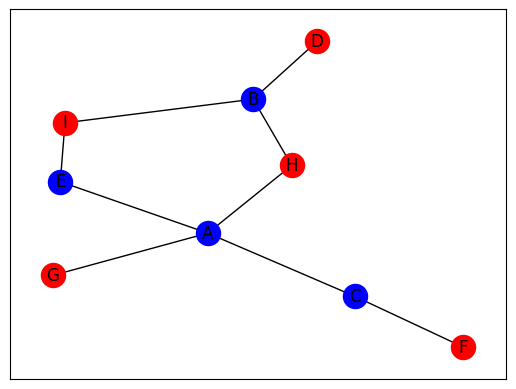

['H', 'I', 'F', 'D', 'G']
['D', 'I', 'G']
H [[{'source': 'H', 'destination': 'A', 'spreading_factor': 8}, {'source': 'A', 'destination': 'H', 'spreading_factor': 8}, {'source': 'H', 'destination': 'B', 'spreading_factor': 7}, {'source': 'B', 'destination': 'H', 'spreading_factor': 7}], [{'source': 'A', 'destination': 'E', 'spreading_factor': 8}, {'source': 'E', 'destination': 'A', 'spreading_factor': 8}, {'source': 'A', 'destination': 'C', 'spreading_factor': 7}, {'source': 'C', 'destination': 'A', 'spreading_factor': 7}], [{'source': 'B', 'destination': 'D', 'spreading_factor': 7}, {'source': 'D', 'destination': 'B', 'spreading_factor': 7}], [{'source': 'I', 'destination': 'E', 'spreading_factor': 12}, {'source': 'E', 'destination': 'I', 'spreading_factor': 12}, {'source': 'B', 'destination': 'I', 'spreading_factor': 7}, {'source': 'I', 'destination': 'B', 'spreading_factor': 7}], [{'source': 'A', 'destination': 'G', 'spreading_factor': 8}, {'source': 'G', 'destination': 'A', 'spreadi

<ipython-input-51-490a8ca7026a>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rect = patches.Rectangle((start, 0), duration, 1, facecolor=plt.cm.get_cmap('hsv')(channel / total_channels))


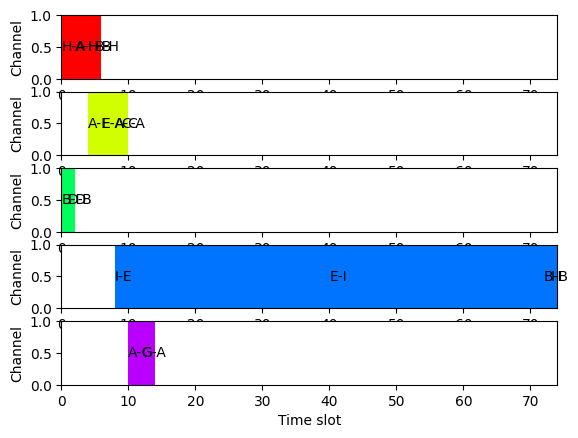

['D', 'H']
I [[{'source': 'I', 'destination': 'E', 'spreading_factor': 12}, {'source': 'E', 'destination': 'I', 'spreading_factor': 12}, {'source': 'I', 'destination': 'B', 'spreading_factor': 7}, {'source': 'B', 'destination': 'I', 'spreading_factor': 7}], [{'source': 'E', 'destination': 'A', 'spreading_factor': 8}, {'source': 'A', 'destination': 'E', 'spreading_factor': 8}], [{'source': 'B', 'destination': 'D', 'spreading_factor': 7}, {'source': 'D', 'destination': 'B', 'spreading_factor': 7}], [{'source': 'H', 'destination': 'A', 'spreading_factor': 8}, {'source': 'A', 'destination': 'H', 'spreading_factor': 8}, {'source': 'B', 'destination': 'H', 'spreading_factor': 7}, {'source': 'H', 'destination': 'B', 'spreading_factor': 7}]]
{0: [{'time_slot': 0, 'transmission': {'source': 'I', 'destination': 'E', 'spreading_factor': 12}}, {'time_slot': 32, 'transmission': {'source': 'E', 'destination': 'I', 'spreading_factor': 12}}, {'time_slot': 64, 'transmission': {'source': 'I', 'destinati

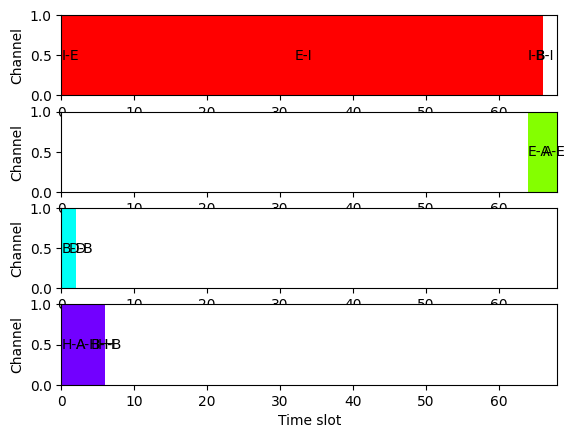

[]
F [[{'source': 'F', 'destination': 'C', 'spreading_factor': 7}, {'source': 'C', 'destination': 'F', 'spreading_factor': 7}], [{'source': 'C', 'destination': 'A', 'spreading_factor': 7}, {'source': 'A', 'destination': 'C', 'spreading_factor': 7}]]
{0: [{'time_slot': 0, 'transmission': {'source': 'F', 'destination': 'C', 'spreading_factor': 7}}, {'time_slot': 1, 'transmission': {'source': 'C', 'destination': 'F', 'spreading_factor': 7}}], 1: [{'time_slot': 2, 'transmission': {'source': 'C', 'destination': 'A', 'spreading_factor': 7}}, {'time_slot': 3, 'transmission': {'source': 'A', 'destination': 'C', 'spreading_factor': 7}}]}


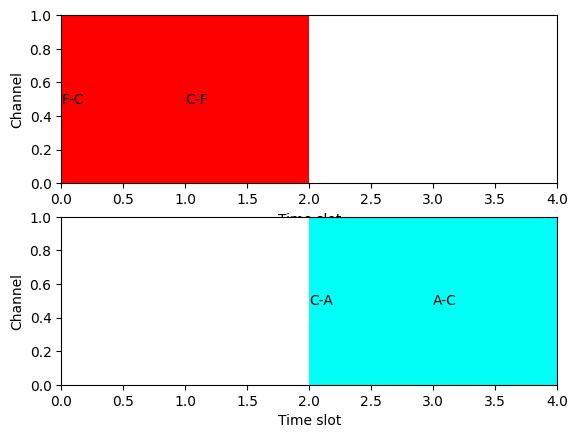

['H', 'I']
D [[{'source': 'D', 'destination': 'B', 'spreading_factor': 7}, {'source': 'B', 'destination': 'D', 'spreading_factor': 7}], [], [{'source': 'B', 'destination': 'H', 'spreading_factor': 7}, {'source': 'H', 'destination': 'B', 'spreading_factor': 7}], [{'source': 'B', 'destination': 'I', 'spreading_factor': 7}, {'source': 'I', 'destination': 'B', 'spreading_factor': 7}]]
{0: [{'time_slot': 0, 'transmission': {'source': 'D', 'destination': 'B', 'spreading_factor': 7}}, {'time_slot': 1, 'transmission': {'source': 'B', 'destination': 'D', 'spreading_factor': 7}}], 2: [{'time_slot': 2, 'transmission': {'source': 'B', 'destination': 'H', 'spreading_factor': 7}}, {'time_slot': 3, 'transmission': {'source': 'H', 'destination': 'B', 'spreading_factor': 7}}], 3: [{'time_slot': 4, 'transmission': {'source': 'B', 'destination': 'I', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'I', 'destination': 'B', 'spreading_factor': 7}}]}


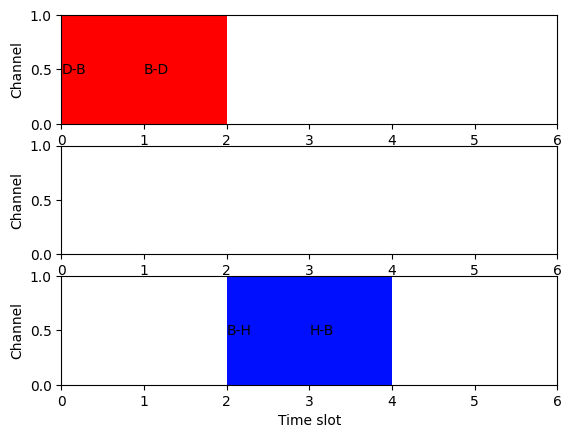

['H']
G [[{'source': 'G', 'destination': 'A', 'spreading_factor': 8}, {'source': 'A', 'destination': 'G', 'spreading_factor': 8}], [{'source': 'A', 'destination': 'E', 'spreading_factor': 8}, {'source': 'E', 'destination': 'A', 'spreading_factor': 8}, {'source': 'A', 'destination': 'C', 'spreading_factor': 7}, {'source': 'C', 'destination': 'A', 'spreading_factor': 7}], [{'source': 'A', 'destination': 'H', 'spreading_factor': 8}, {'source': 'H', 'destination': 'A', 'spreading_factor': 8}]]
{0: [{'time_slot': 0, 'transmission': {'source': 'G', 'destination': 'A', 'spreading_factor': 8}}, {'time_slot': 2, 'transmission': {'source': 'A', 'destination': 'G', 'spreading_factor': 8}}], 1: [{'time_slot': 4, 'transmission': {'source': 'A', 'destination': 'E', 'spreading_factor': 8}}, {'time_slot': 6, 'transmission': {'source': 'E', 'destination': 'A', 'spreading_factor': 8}}, {'time_slot': 8, 'transmission': {'source': 'A', 'destination': 'C', 'spreading_factor': 7}}, {'time_slot': 9, 'transmi

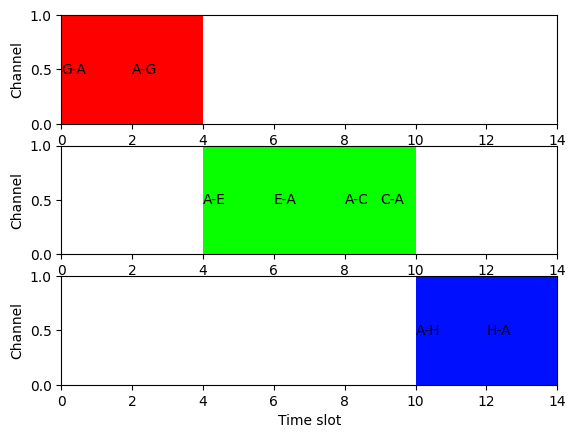

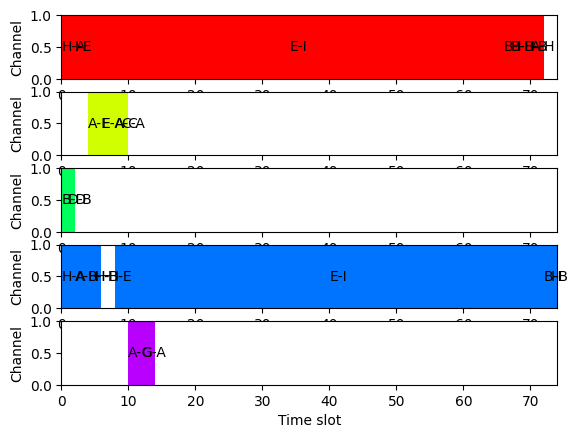

In [ ]:
Network = generate_graph()

Dom_set = list(compute_dominating_set(Network))
draw_graph(Network, Dom_set)
K_d = list_known_dominators(Network, Dom_set)
transmissions = list_transmissions(Network, Dom_set)
CLIST = []

print(Dom_set)

G_sch = []
Merged_sch=[]


for node in Dom_set:
  a=K_d[node]
  print(a)
  CLIST=channel_list(transmissions,node, K_d)
  print(node, CLIST)
  Schedule = schedule_transmissions(node,CLIST)
  G_sch.append(Schedule)
  print(Schedule)
  total_channels=len(Schedule)
  df=visualize_schedule(Schedule, total_channels)


Merged_sch = merge_schedules(G_sch[0], G_sch[1])
m_channels = len(Merged_sch)
Mdf=visualize_schedule(Merged_sch, m_channels)